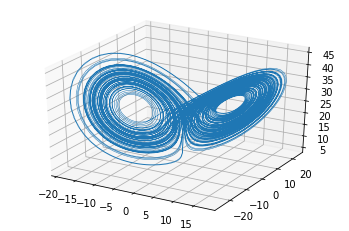

In [2]:
import numpy as np
import networkx as nx
from numpy.linalg import inv
from numpy.linalg import matrix_rank
from scipy.sparse import random
import scipy.sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def lorenz(x):
    sigma = 10.
    rho = 28.
    b = 8/3
    np.array(x)
    return  np.array([sigma*(x[1]-x[0]), x[0]*(rho-x[2])-x[1], x[0]*x[1] - b*x[2]])

def runge_kutta(f, dt, y=np.array([2.2,-3.5,4.3])):
    k1 = dt*f(y)
    k2 = dt*f(y+k1/2)
    k3 = dt*f(y+k2/2)
    k4 = dt*f(y + k3)
    return y + 1./6*(k1+2*k2+2*k3+k4)

def record_trajectory(dt, timesteps, starting_point):

    traj = np.zeros([timesteps, 3])
    y = starting_point   
    for t in range(timesteps):
        traj[t] = y
        y = runge_kutta(lorenz, dt, y=y)
    return traj

signal = record_trajectory(0.01, 70000, np.array([-5., 4., 2.]))
signal = signal[10000:]

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.plot(signal[:10000, 0], signal[:10000, 1], signal[:10000, 2], lw=0.5)
plt.show()

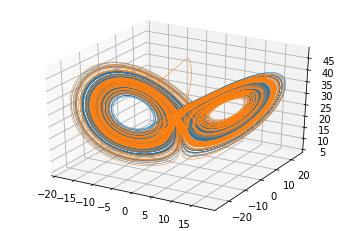

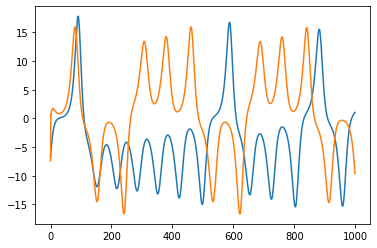

In [8]:
def reservoir_computing(data, network_dimension, network_edges, network_radius, regularization,
                       signal_dimension, discarding_steps, training_steps, prediction_steps):
     
    signal = data
    network = np.asarray(nx.to_numpy_matrix(nx.fast_gnp_random_graph(network_dimension, network_edges)))
    index_nonzero = np.nonzero(network) 
    network[index_nonzero] = np.random.uniform(-1,1, np.count_nonzero(network))
    network = (network_radius/np.absolute(np.linalg.eigvals(network)).max()) * network
    network = scipy.sparse.csr_matrix(network)
    W_in = np.zeros((network_dimension, signal_dimension))            
    for i in range(network_dimension):
        random_x_coord = np.random.choice(np.arange(signal_dimension))
        W_in[i, random_x_coord] = np.random.uniform(-0.5, 0.5)                         #initializing weights
    W_in = scipy.sparse.csr_matrix(W_in)
    
    r = np.zeros([training_steps, network_dimension])
    t = 0
    while t < discarding_steps+training_steps-1:
        if t < discarding_steps:
            r[0] = np.tanh(W_in @ signal[t] + network @ r[0])        
        else:
            r[t-discarding_steps+1] = np.tanh(W_in @ signal[t] + network @ r[t-discarding_steps])
        t+=1  
    R = r    
    R[:, 1::2] = R[:, 1::2]**2
    W_out =  np.linalg.solve((R.T @ R + regularization * np.eye(R.shape[1])), (
               R.T @ (signal[discarding_steps:discarding_steps+training_steps]))).T
    W_1 = np.zeros([signal_dimension, network_dimension])
    W_1[:, 0::2] = W_out[:, 0::2]
    W_2 = np.zeros([signal_dimension, network_dimension])
    W_2[:, 1::2] = W_out[:, 1::2]
    
    r = r[-1] 
    prediction = np.empty([prediction_steps, signal_dimension])
    prediction[0] = W_1 @ r + W_2 @ r**2
    t = 0
    while t < prediction_steps-1:
        r = np.tanh(W_in @ prediction[t] + network @ r)
        prediction[t+1] = W_1 @ r + W_2 @ r**2                      #prediction
        t+=1  
    
    test = signal[discarding_steps+training_steps:discarding_steps+training_steps+prediction_steps]
    return prediction, test

signal_pred, signal_test = reservoir_computing(signal[300:], network_dimension=2000, network_edges=0.05, 
                                               network_radius=0.1, regularization=0.0001, 
                                               signal_dimension=3, discarding_steps=1000, 
                                               training_steps=10000, prediction_steps=10000)
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.plot(signal_test[:, 0], signal_test[:, 1], signal_test[:, 2], lw=0.5)
plt.plot(signal_pred[:, 0], signal_pred[:, 1], signal_pred[:, 2], lw=0.5)
plt.show()
plt.plot(signal_test[0:1000, 0])
plt.plot(signal_pred[0:1000, 0])
plt.show()